In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [144]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [145]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [146]:
# Reading channels
data = Data[1]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [334]:
# Para el caso 1 canal
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [335]:
def Gauss(x,mean=1.,sigma=0.2):
    return norm.pdf(x,loc=mean,scale=sigma)

In [336]:
def Poisson(n,l):
    return poisson.pmf(n,mu=l)

In [337]:
Poisson(5,4)

0.1562934518505317

In [338]:
def Poisson1(n,l):

    if l > 0.:
        log_likelihood = -l + n*np.log(l) - gammaln(n+1)  # Softening parameter
        return np.exp(log_likelihood)
    else:
        return 0.

In [339]:
Poisson1(5,1)

0.00306566200976202

In [340]:
def Likelihood(p,sigma,n,b,s):

    mu,e = p
    l = mu*s+e*b
    
    return Poisson1(n,l)*Gauss(e,1.,sigma=sigma)

In [341]:
# Probando la funcion de likelihood
Likelihood(np.array([0.4,1.]),0.1,n[0],b[0],s[0])

0.15445412480195864

In [342]:
def GetJointLikelihood(p,sigma,n,b,s):

    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(p,sigma,n[c],b[c],s[c]))

    return JointLike

In [343]:
GetJointLikelihood(np.array([0.4,1.]),0.1,n,b,s)

3.7357163071680115

In [344]:
mu = np.linspace(0.01,3,30)
e = np.linspace(0.6,1.4,30)
Mu,E = np.meshgrid(mu,e)
Surface = np.zeros_like(Mu)

for i in range(len(mu)):
    for j in range(len(e)):
        like = GetJointLikelihood(np.array([mu[i],e[j]]),0.1,n,b,s)
        Surface[i,j] = like

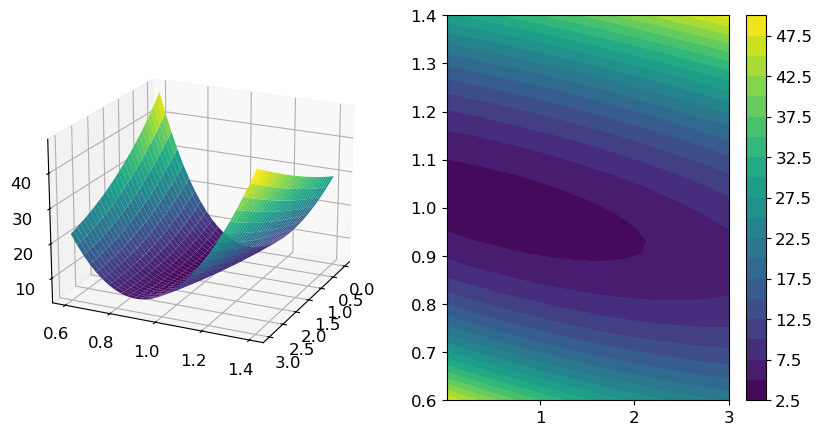

In [345]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, projection='3d', elev = 20, azim = 25)
ax.plot_surface(Mu,E,Surface.T, cmap='viridis')
ax1 = fig.add_subplot(1,2,2)
c = ax1.contourf(Mu,E,Surface.T,20,cmap='viridis')
fig.colorbar(c,ax=ax1)

In [346]:
def GetJointLikelihoodNuissance(p,mu,sigma,n,b,s):

    e = p[0]
    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(np.array([mu,e]),sigma,n[c],b[c],s[c]))

    return JointLike

In [347]:
GetJointLikelihoodNuissance(np.array([1.]),1.,0.1,n,b,s)

3.956928310448823

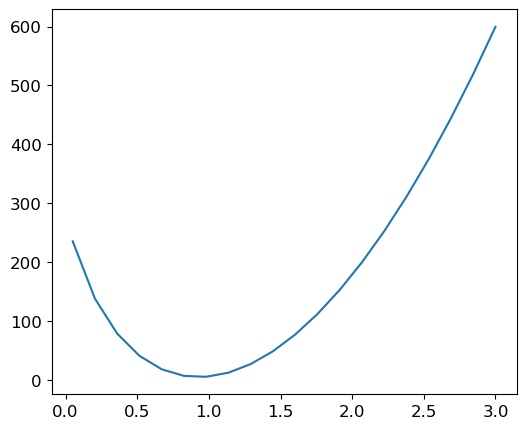

In [348]:
e = np.linspace(0.05,3,20)
perfil = np.zeros_like(e)
for i in range(len(e)):
    perfil[i] = GetJointLikelihoodNuissance(np.array([e[i]]),2.0,0.1,n,b,s)
plt.plot(e,perfil)

In [349]:
def GetHat(n,b,s,sigma=0.1):

    bounds = ((0,50),(0,10))
    p0 = np.array([1.,1.])
    result = spo.minimize( GetJointLikelihood, p0, args=(sigma,n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Hat = result.x

    return Hat

In [350]:
GetHat(n,b,s,0.1)

array([0.49996987, 1.00000148])

In [351]:
def GetDoubleHat(mu,sigma,n,b,s):
    
    bounds =  ((0,10),)
    p0 = np.array([1.])
    result = spo.minimize( GetJointLikelihoodNuissance, p0, args=(mu,sigma,n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Doublehat = result.x[0]

    return Doublehat

In [352]:
#mu = np.linspace(0.05,3,20)
#for i in range(len(mu)):
#    d = GetDoubleHat(mu[i],0.1,n,b,s)
#    print(d)

In [354]:
# Probando
GetDoubleHat(3.0,0.1,n,b,s)

0.88564453125

In [101]:
GetHat(n,b,s,0.3)

array([0.50003274, 0.99999695])

In [48]:
# Probando funciones hat and double hat

In [387]:
def GetqmObs(mu,sigma,n,b,s):

    doublehat = GetDoubleHat(mu,sigma,n,b,s)
    hat = GetHat(n,b,s,sigma)
   # print(doublehat)
   # print(hat)
    
    qm = 0.
    
    for c in range(N):
        
        if mu > hat[0]:
            qm += -2*np.log( Likelihood(np.array([mu,doublehat]),sigma,n[c],b[c],s[c]) / Likelihood(hat,sigma,n[c],b[c],s[c]) ) 
        else:
            qm += 0.
            
    return qm

In [391]:
qmObs = GetqmObs(1.2,sigma=0.1,n=n,b=b,s=s)
qmObs

0.23624002128064142

In [396]:
# Expected
qmObsE = GetqmObs(1.2,sigma=0.1,n=b,b=b,s=s)
qmObsE

0.7056077651675925

In [398]:
mu = np.linspace(0.1,5.0,20)
qmObsEV = np.zeros_like(mu)
qmObsEV1 = np.zeros_like(mu)
qmObsEV2 = np.zeros_like(mu)

for i in range(mu.shape[0]):
    qmObsEV[i] = GetqmObs(mu[i],sigma=0.05,n=n,b=b,s=s)
    qmObsEV1[i] = GetqmObs(mu[i],sigma=0.1,n=n,b=b,s=s)
    qmObsEV2[i] = GetqmObs(mu[i],sigma=0.2,n=n,b=b,s=s)

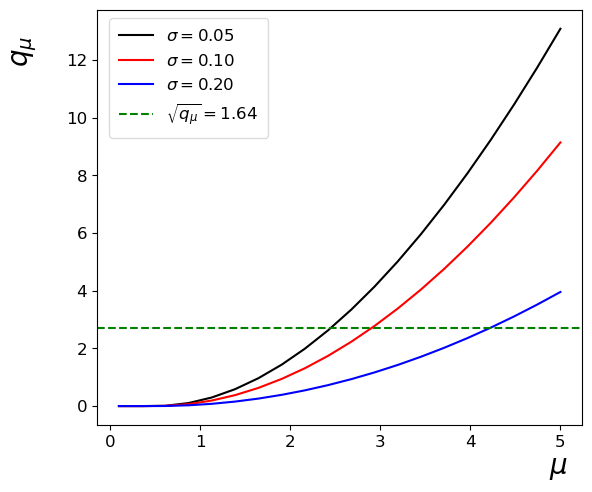

In [399]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mu,qmObsEV,color='k',label=r'$\sigma=$%.2f'%(0.05))
ax.plot(mu,qmObsEV1,color='r',label=r'$\sigma=$%.2f'%(0.1))
ax.plot(mu,qmObsEV2,color='b',label=r'$\sigma=$%.2f'%(0.2))

ax.axhline(y=norm.ppf(0.95)**2,ls='--',color='g',label=r'$\sqrt{q_{\mu}}=1.64$')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$q_{\mu}$')
ax.yaxis.set_label_coords(-0.12,0.90)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(0.37,1),ncol=1,title='')


#
plt.savefig('qm_plot_systematic.pdf')

In [423]:
def Getqm(mu,sigma=0.1,Null=True):
    
    Ntoys = np.zeros(N)
   
    for c in range(N):
        
        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson(mu*s[c]+b[c])
          
        Ntoys[c] = ntoy
        
    return GetqmObs(mu,sigma=sigma,n=Ntoys,b=b,s=s)

In [540]:
def Sampler(mu, Ntoys = int(5e2),sigma=0.1):
    
    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    print(sigma)
    for i in range(Ntoys):
        q0[i] = Getqm(mu,sigma,Null=True)
        q1[i] = Getqm(mu,sigma,Null=False)
        
    return q0,q1

In [541]:
mu = 2.
q0,q1 = Sampler(mu,sigma=0.3)
qmObs = GetqmObs(mu,sigma=0.3,n=n,b=b,s=s)
p0 = GetPValue(q0,qmObs)
p1 = GetPValue(q1,qmObs)
print(p0,p1,p1/p0)

0.3
0.714 0.072 0.10084033613445378


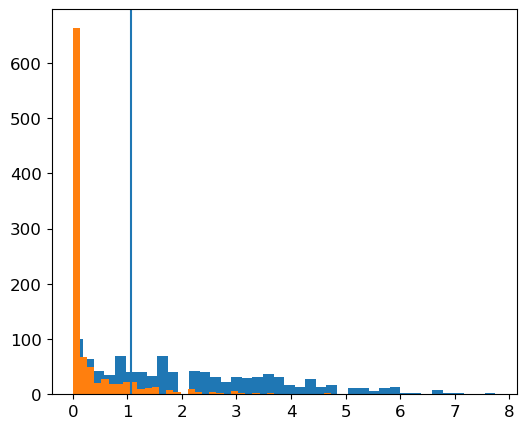

In [534]:
plt.hist(q0,bins=40)
plt.hist(q1,bins=40)
plt.axvline(x=qmObs)

In [535]:
def GetPValue(data,Qobs):

    count_above_threshold = np.sum( data >= Qobs )
    p_value = count_above_threshold / data.shape[0]

    return p_value

In [536]:
def GetCls_for_mu(i,mu, Expected=False):

    sigma = 0.3
    print(f"[DEBUG] Iniciando GetCls_for_mu con sigma={sigma} para mu={mu}")
    if Expected:
        qmObs = GetqmObs(mu,sigma=sigma,n=b,b=b,s=s)
    else:
        qmObs = GetqmObs(mu,sigma=sigma,n=n,b=b,s=s)
            
    q0,q1 = Sampler(mu,sigma=sigma)

    p0 = GetPValue(q0,qmObs)
    p1 = GetPValue(q1,qmObs)

    if p0 != 0:
        Cls = p1/p0
    else:
        print('Problemas con la hipotesis nula')
        Cls = p1

    return i,Cls

In [537]:
#mu = np.linspace(2.,4.,3)
#for i in range(len(mu)):
#    print(GetCls_for_mu(0,mu[i],sigma=0.1)[1])

In [538]:
mu = np.linspace(2.,4.,4)
for i in range(len(mu)):
    print(GetCls_for_mu(0,mu[i])[1])

[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=2.0
0.3
0.1119186046511628
[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=2.6666666666666665
0.3
0.03566529492455418
[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=3.333333333333333
0.3


KeyboardInterrupt: 

In [525]:
def GetCls_parallel1(mu, Expected=False, sigma = 0.1,num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = np.array([])

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):
            futures = np.append(futures,executor.submit(GetCls_for_mu, i, mu[i], Expected))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Cls = future.result()
            p_value[i] = Cls

    return p_value

In [526]:
def GetCls_parallel(mu, Expected=False, sigma=0.1, num_processors=None):
    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:
        # Usar map para pasar mu y sigma directamente
        results = list(executor.map(GetCls_for_mu, range(mu.shape[0]), mu, [Expected]*len(mu), [sigma]*len(mu)))

    # Recoger resultados
    for i, Cls in results:
        p_value[i] = Cls

    return p_value

In [527]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [528]:
mu = np.linspace(2.,4.,4)

In [512]:
Op_value = GetCls_parallel1(mu,Expected=False,sigma=0.1,num_processors=8)
GetUpperLimit(mu,Op_value)

  0%|                                                                                                       | 0/4 [00:00<?, ?it/s]

[DEBUG] Iniciando GetCls_for_mu con sigma=0.1 para mu=2.0[DEBUG] Iniciando GetCls_for_mu con sigma=0.1 para mu=2.6666666666666665

[DEBUG] Iniciando GetCls_for_mu con sigma=0.1 para mu=3.333333333333333[DEBUG] Iniciando GetCls_for_mu con sigma=0.1 para mu=4.0



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.59s/it]


2.5103640826728126

In [511]:
Op_value

array([0.10335196, 0.03366059, 0.00979021, 0.00275103])

In [529]:
Op_value1 = GetCls_parallel1(mu,Expected=False,num_processors=8)
print(Op_value1)
GetUpperLimit(mu,Op_value1)

  0%|                                                                                                       | 0/4 [00:00<?, ?it/s]

[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=2.0[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=2.6666666666666665[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=3.333333333333333


[DEBUG] Iniciando GetCls_for_mu con sigma=0.3 para mu=4.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.99s/it]

[0.10335196 0.03366059 0.00979021 0.00275103]


2.5103640826728126

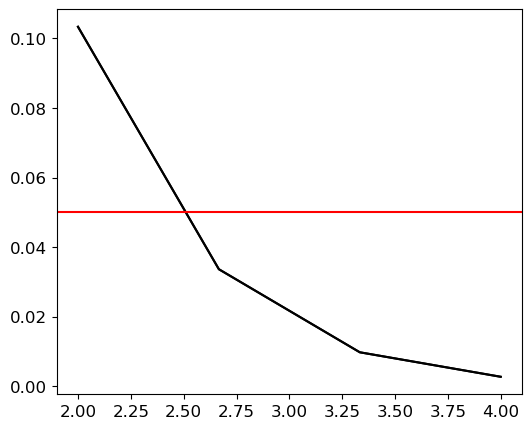

In [514]:
plt.plot(mu,Op_value,color='k')
plt.plot(mu,Op_value1,color='k')
plt.axhline(y=0.05,color='r')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


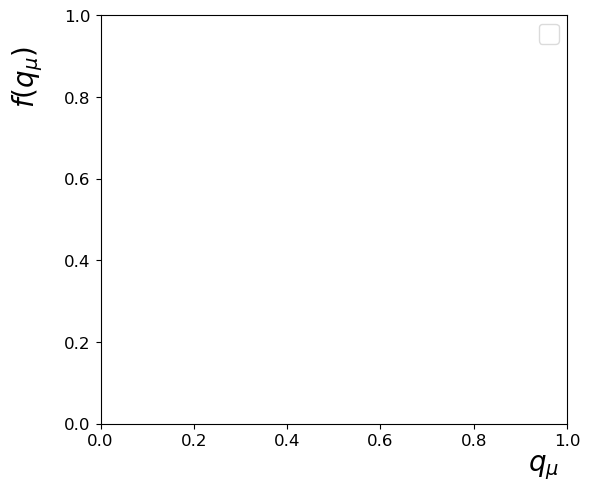

In [71]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.hist(q0,bins=35,color='green',density=True,label=r'$f(q_{\mu};0)$')
#ax.hist(q1,bins=35,color='yellow',density=True,label=r'$f(q_{\mu};\mu)$')
#ax.axvline(x=qmObs,color='k',label=r'$q_{\mu,obs}$')

# Label X
ax.set_xlabel(r'$q_{\mu}$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$f(q_{\mu})$')
ax.yaxis.set_label_coords(-0.12,0.85)

#ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
#plt.savefig('Distribution_qm.pdf')